# Procesamiento Digital de Audio
## Caleb Rascón
### Estimación de Múltiples Direcciones de Arribo
#### MUSIC

In [11]:
# Bibliotecas
import numpy as np
from numpy import fft
from matplotlib import pyplot as plt

### Setup

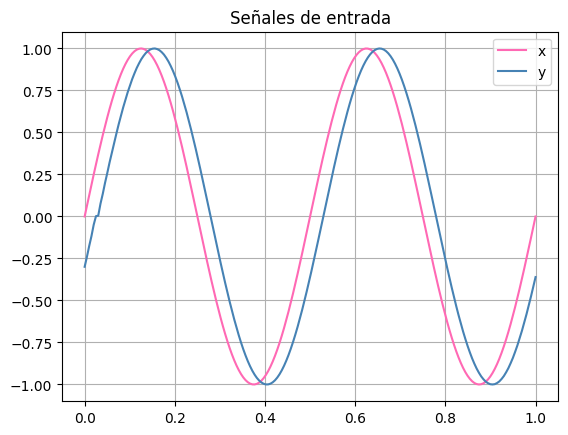

In [18]:
# Direction of arrival of the signal in degrees
doa = 30
# Distance between microphones in meters
d = 20

# Noise presence (between 0 and 1)
noise_w = 0.0

# Signal size in samples, also frequency sampling
K = 200
# Frequency vector
w = np.concatenate( (np.arange(0,K//2 + 1), np.arange(-K//2 + 1, 0)) )

####################

# Base frequency of signal of interest (SOI)
freq = 2
# Speed of sound
c = 343
# Time vecto (1 second)
t = np.arange(K) / (K-1)

# Number of signals in signal sub-space
r = 1
# Number of microphones
N = 1

# Defining the original SOI
s1 = np.sin(2*np.pi*freq*t)

# First mic, steering vector equal to 1, no delay
x = s1

# Second mic, delayed one distance
y = np.real( fft.ifft(fft.fft(s1)* np.exp(-1j*2*np.pi*w*(d/c)*np.sin(doa*np.pi/180))))

# Adding noise
x = x + np.random.randn(K)*noise_w/10
y = y + np.random.randn(K)*noise_w/10

plt.plot(t,x,label='x',color='hotpink')
plt.plot(t,y,label='y',color='steelblue')
plt.title("Señales de entrada")
plt.grid()
plt.legend()
plt.show()


In [22]:
# Data matrix
X = np.array([fft.fft(x), fft.fft(y)])

### MUSIC

In [37]:
# Define angles to look for orthogonality
angles = np.arange(-90,90,.1)
music_spectrum = np.zeros(len(angles))